In [1]:
##########################################################
## Générateur de librairies VHDL - FPGA AMD             ##
##########################################################
##            AllProduct_VHDL_PKG-01                    ##
##            ----------------------                    ##
##                                       24-04-2025     ##
## Programme générateur de toutes les libs et PKGs pour ##
## la génération de code VHDL automatisé -> BINDER.vhd  ##
##                                                      ##
## Fusion code -> NPYtoTXT_VHDLfile-01.ipynb            ##
##                SpikeTraceGen-04.ipynb                ##
##                NET-SRC-JSON-All-03.ipynb             ##
##                                                      ##
##                                       03-05-2025     ##     
## Version 1 - pas de corrections - add min max         ##
##                                - add sumpos sumneg   ##
##                                                      ##          
##########################################################
##########################################################
##                 SpikeTrace 1                         ##
##                 ------------                         ##
##                                       16-04-2025     ##
## Programme générateur de SpikeTrace pour code VHDL    ##
## Version 1 - construction du spikeTrace suivant la    ##
##             norme VHDL 2007 -> WORK.PACKAGE          ##
## Fusion code -> neant                                 ##
##                                       22-04-2025     ##     
## Version 2 - ADD - matrice complète en 220            ##
##                 - nombre à reconnaître en 221        ##          
##########################################################
## Simulation d'un réseau de neurones - Li=100 et Lo=10 ##
##########################################################
##                 FPGA Model 1                         ##
##                 ------------                         ##
##                                       29-01-2024     ##
## programme test de l'ensemble des paramètres calculés ##
## par Florent.                                         ##
## Les données d'entrées -> MNIST recalculé en train de ##
## spikes avec longueur préfix null = 20                ##
##             longueur du train = 200                  ##
##             longueur suffix null = 0                 ##
## Ensemble des paramètres contenu dans un fichier JSON ##
## Ensemble des coéfficients des équations diff. -> NPZ ##
##                                                      ##
## génération du vecteur de spike suivant le chiffre    ##
## choisi et lecture et analyse de ce vecteur par le    ##
## réseau de neurones -> en sortie le chiffre détecté.  ##
##                                                      ##
##                Pascal Harmeling 2024 - Uliège        ##
## Version 1 - Adapation du code 'NET-SRC-JSON-All-07'  ##
##             du répetroire '11 - RNN-SRC-NET-All 01'  ##
##             afin de préparer le code VHDL            ##
##           - Utilisation de la lib 'FpgaLib-01.jl'    ##
##             et remplacement des fonctions adaptées   ##
##           - mise en place d'une interface pour mise  ##
##             à l'échelle (de -1..+1 à -1000..+1000).  ##
##             pour le courant d'entrée.                ##
##             En sortie l'opération                    ##
##                 ifelse(hp[i,j]>0,hp[i,j],0)          ##
##             assure l'interface.                      ##
##           - Fparam coeff. Base [2]= 985              ##
## Version 2 - Adaptation calcul Rout[] pour FPGA       ##
##             coeff. 10 ou -1                          ##
## Version 3 - Adaptation calcul de IS et USP pour une  ##
##             FPGA.                                    ##
##########################################################

##########################################################
# CHOISIR UNE IMAGE -> SPIKINGTRACE_PKG.VHD              #
##########################################################
Img=1 #value between [1 - 10000] -> 

##########################################################
## PAS DE GRAPHIQUE NI INTERACT lib POUR LA RAPIDITE!   ##
##########################################################

# pour la lecture et le traitement du fichier JSON
using JSON3

# pour la lecture et le traitement du fichier NPZ
using NPZ

# pour la lecture et le traitement du fichier MNIST
using MLDatasets

# utilisation pour généréer les spikes des entrées des neurones - a=rand(Bernoulli(0.9), 100)
using Distributions

# utilisation si nécessaire pour affichage de résultats
using Plots
using Printf
#using Interact, WebIO
using LaTeXStrings

# utilisation de ma lib pour le modèle neuro - perso et Florent - pour mémoire 
# def using my lib -> neurone evec struct et fonction - entrées de spikes par vecteurs
include("../MyLib/FpgaLib-01.jl")


NeSRCFpgaBurst3! (generic function with 1 method)

In [2]:
##########################################################
## Création méthodes de lecture fichier JSON3           ##
##########################################################
## programme pour la mise en place d'une lib            ##
## de lecture des différents paramètres codés dans un   ##
## fichier JSON3                                        ##
##                                                      ##
##                Pascal Harmeling 2023 - Uliège        ##
##                                                      ##
##########################################################

#################################################
## Function use JSON file input - read values  ##
#################################################
json_string = read("model/config.json", String)

FileJson = JSON3.read(json_string)

# principe d'accès aux éléments de la structure de données.
const cell_config_alphas=FileJson.cell_config.alphas
const cell_config_recurrence=FileJson.cell_config.recurrence
const cell_config_bias_max=FileJson.cell_config.bias_max
const cell_config_activation=FileJson.cell_config.activation
const cell_config_type=FileJson.cell_config.type
const cell_config_num_integrators_per_neuron=FileJson.cell_config.num_integrators_per_neuron

const dataset_config_encoding=FileJson.dataset_config.encoding
const dataset_config_seq_length::Int16=FileJson.dataset_config.seq_length
const dataset_config_prefix_length=FileJson.dataset_config.prefix_length
const dataset_config_suffix_length=FileJson.dataset_config.suffix_length
const dataset_config_rate_gain=FileJson.dataset_config.rate_gain
const dataset_config_name=FileJson.dataset_config.name
    
const input_size=FileJson.input_size
const hidden_size=FileJson.hidden_size
const hidden_layers=FileJson.hidden_layers
const output_size=FileJson.output_size
const readout_input_factor=FileJson.readout_input_factor


10

In [3]:
##########################################################
## Création méthodes de lecture fichier NPY             ##
##########################################################
## programme pour la mise en place d'une lib            ##
## de lecture des différents paramètres codés dans un   ##
## fichier NPY                                          ##
##                                                      ##
##                Pascal Harmeling 2023 - Uliège        ##
##                                                      ##
##########################################################

#################################################
## Function use NPY file input - read values   ##
#################################################

vars=npzread("model/arrays.npz")

#récupération des différents paramètres et valeurs initiales - si nécessaire vectorisation (vec())
const bias=get(vars,"l0_bias", 0)
const forward_weights=get(vars,"l0_forward_weights", 0)
const forward_weightsp=round.(Int16,(get(vars,"l0_forward_weights", 0)./(1/256)))
const initial_h=get(vars,"l0_initial_h", 0)
const initial_hs=get(vars,"l0_initial_hs", 0)
const initial_i=vec(get(vars,"l0_initial_i", 0)[1,:,1])   #VECTORISATION 
const r=get(vars,"l0_r", 0)
const rho=get(vars,"l0_rho", 0)
const rs=get(vars,"l0_rs", 0)
const zs_dep=vec(get(vars,"l0_zs_dep", 0)[1,:])
const zs_hyp=vec(get(vars,"l0_zs_hyp", 0)[1,:])
const readout=get(vars,"readout", 0)
const readoutp=round.(Int8, readout.*10)


10×100 Matrix{Int8}:
 10  -1  -1  -1  -1  -1  -1  -1  -1  …  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  10  -1  -1  -1  -1  -1  -1  -1     10  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  10  -1  -1  -1  -1  -1  -1     -1  10  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  10  -1  -1  -1  -1  -1     -1  -1  10  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  10  -1  -1  -1  -1     -1  -1  -1  10  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  10  -1  -1  -1  …  -1  -1  -1  -1  10  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  10  -1  -1     -1  -1  -1  -1  -1  10  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  10  -1     -1  -1  -1  -1  -1  -1  10  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  10     -1  -1  -1  -1  -1  -1  -1  10  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  10

In [11]:
##########################################################
## Lecture MNIST et génération Spiking train            ##
##########################################################
## programme pour la mise en place d'une lib            ##
## réalisant la lecture du fichier MNIST.               ##
## conversion en train de spikes d'un des éléments de   ##
## MNIST sur base d'un Interactive slide.               ##
## -> utilisation de la fonction proba Bernoulli avec   ##
##    un gain (0<=gain<=1).                             ##
##                                                      ##
##                Pascal Harmeling 2023 - Uliège        ##
##                                                      ##
##########################################################

train_x, train_y = MNIST(split=:test)[:]

#const rate_gain=0.25
const Gain = 0.250

# nombre d'éléments dans les tableaux et parcour boucles- constantes divers
const Seq_length = dataset_config_seq_length
const Total_seq_length=dataset_config_prefix_length+dataset_config_seq_length+dataset_config_suffix_length
const DataFirst = dataset_config_prefix_length+1
const DataEnd = dataset_config_prefix_length+dataset_config_seq_length

# Mise en place des vecteurs
STs = size(train_x)
global TSspikes = zeros(Bool, STs[1],STs[2],Total_seq_length)

#initialisation des variables is, us
is=zeros(Float32,Total_seq_length,100)
us=zeros(Float32,Total_seq_length,100)

#initialisation des variables h, z, hs, Sout et Rout - méthode de Florent
h=zeros(Float32,Total_seq_length,100)
z=zeros(Float32,Total_seq_length,100)
hs=zeros(Float32,Total_seq_length,100)
Sout=zeros(Float32,Total_seq_length,100)

Rout=zeros(Float32,Total_seq_length,10)

#initialisation des variables hp, zp, hsp, Soutp et Rout - méthode de Pascal
isp=zeros(Int32,Total_seq_length,100)

isps::Int16=-1000

hp=zeros(Int16,Total_seq_length,100)
zp=zeros(Int16,Total_seq_length,100)
hsp=zeros(Int16,Total_seq_length,100)

Soutp=zeros(Int8,Total_seq_length,100)

Routp=zeros(Int32,Total_seq_length,10)

#paramètres obtenus lors des calculs du le projet
const Fparam=Vector{Int16}(undef,5)
Fparam[1] = -3000
Fparam[2] = 885 # modification - permet d'adapter la fréquence des spikes - ATTENTION AVANT 0.99 -> Coeff. 1000 -- test avec 970
Fparam[3] = 100

#initialisation des spikes time
TSspikes = zeros(Bool, STs[1],STs[2],Total_seq_length)
Spi=100
TauxErrorF::Int16 = 0
TauxErrorP::Int16 = 0

#gestiondu temps durée de la boucle
t1=time()

for Img in 1:10000       #value between [1 - 10000]
    
    # SPIKES TIMES - Mise en place des vecteurs d'impulsion spikes - 
    # SPIKES TIMES - on va utiliser les mêmes spikes times pour les deux méthodes de résolution
    filename = "./MNIST/NPY/spiking_number" * lpad(string(Img), 5, '0') * ".npy"
    global TSspikes=npzread(filename)
    
    ##########################################################
    ## activité neuronal - analyse du train de Spikes       ##
    ##########################################################
    ## programme qui réalise la simulation d'un réseau de   ##
    ## neurones. Le réseau analyse un train de spikes afin  ##
    ## de retourner en sorite la valeur                     ##
    ## MNIST sur base d'un Interactive slide.               ##
    ## -> utilisation de la fonction proba Bernoulli avec   ##
    ##    un gain (0<=gain<=1).                             ##
    ##                                                      ##
    ##                Pascal Harmeling 2023 - Uliège        ##
    ##                                                      ##
    ##########################################################
    
    # Réalisation de la simulation du réseaux de neurones SSN -> SRC
    # 2 méthodes sont utilisée - méthode de Florent et méthode de Pascal.
    for i in 1:(Total_seq_length)
        
        #picture (2D) to vector
        VTSspikes=vec(TSspikes[:,:,i])
        
        #calcul des 100 SRC
        for j in 1:100
            
            #calcul du courant 'is' et de la tension 'us' suivant (forward_weights,VTSspikes,cell_config_alphas,rho)
            if i==1 #condition initiale de i
                global is[1,j]=sum(forward_weights[j,:].*VTSspikes)+initial_i[j]
                global isp[1,j]=sum(forward_weightsp[j,:].*VTSspikes)<<5
            else
                # global is[i,j]=is[i-1,j]*cell_config_alphas[1] + sum(forward_weights[j,:].*VTSspikes) - test shift divisor 16 et 32
                global is[i,j]=(is[i-1,j] - (is[i-1,j]/16 + is[i-1,j]/32)) + sum(forward_weights[j,:].*VTSspikes)
                global isp[i,j]=(isp[i-1,j] - (isp[i-1,j]>>4 + isp[i-1,j]>>5)) + (sum(forward_weightsp[j,:].*VTSspikes)<<5)
            end
            global us[i,j]=rho[j]*tanh((1/rho[j])*is[i,j])        
                        
            #Calcul suivant la méthode de  ------------- FLORENT -------------
            #calcul de h, z, hs et Sout
            if i==1   #conditions initiales h,z et hs
                global h[1,j]=initial_h[j]
                global z[1,j]=zs_hyp[j]- (zs_hyp[j] - zs_dep[j]) * (1 / (1+exp(-10 * -0.5)))
                global hs[1,j]=initial_hs[j]
            else
                global h[i,j]=tanh(us[i,j] + r[j]*h[i-1,j] + rs[j]*hs[i-1,j] + bias[j])
                global z[i,j]=zs_hyp[j]- (zs_hyp[j] - zs_dep[j]) * (1 / (1+exp(-10 * (h[i-1,j]-0.5))))
                global hs[i,j]=z[i,j]*hs[i-1,j]+(1-z[i,j])*h[i-1,j]
            end
            Sout[i,j]=ifelse(h[i,j]>0,h[i,j],0) 
            
            #Calcul suivant la méthode de  ------------- PASCAL ------------- lib 
            #calcul de hp, zp, hsp et Soutp
            if i==1   #conditions initiales h,z et hs
                global hp[1,j]=-1024                # -1024
                global hsp[1,j]=-800                # -800
                global zp[1,j]=885
            else
                if isp[i,j]>0         # !!!! Peut être modifier la valeur de référence (0.91 dans la version précédente)
                    # courant d'entrée ok -> excitation .. + 1000
                    isps = 1023
                else
                    # pas de courant d'entrée .. -1000
                    isps = -1024
                end
                global hp[i,j],hsp[i,j],zp[i,j]=NeSRC3Fpga5!(isps, hp[i-1,j], hsp[i-1,j], Fparam)
            end
            # cette comparaison permet de faire une interface simple de sortie -> rien à faire
            # la valeur de seuil (ici 400 par défaut) peut être ajustée pour optimiser le résultat
            Soutp[i,j]=ifelse(hp[i,j]>400,1,0) 
            
        end

        #calcul les 10 Rout
        for j in 1:10
           #Calcul suivant la méthode de  ------------- FLORENT -------------
           if i==1
                #calcul le vecteur d'entrée (100 éléments)
                global Rout[i,j]=sum(readout[j,:].* Sout[i,:])
            else
                global Rout[i,j]=Rout[i-1,j]+sum(readout[j,:].* Sout[i,:]) # # feedback = 0.98
                #global Rout[i,j]=0.99*Rout[i-1,j]+sum(readout[j,:].* Sout[i,:]) # # feedback = 0.99
                #global Rout[i,j]=Rout[i-1,j]+sum(readout[j,:].* Sout[i,:]) # # feedback = 1
            end

            #Calcul suivant la méthode de  ------------- PASCAL -------------
           if i==1
                #calcul le vecteur d'entrée (100 éléments)
                global Routp[i,j]=sum(readoutp[j,:].* Soutp[i,:])
            else
                # global Routp[i,j]=0.984*Routp[i-1,j]+sum(readoutp[j,:].* Soutp[i,:])
                # la division par 128 permet dans la FPGA de réaliser '>>7'
                # le remplacement par un test if de la solution de produit '.*' par une somme simplifiée ----------- todo -----------------
                # dans le code VHDL on remplacera le produit par une somme dans une boucle avec : 
                #    - si *1 -> add Soutp
                #    - si *10 -> add (Soutp<<3 + Soutp<<1) 
                #
                global Routp[i,j]=(Routp[i-1,j])+(sum(readoutp[j,:].* Soutp[i,:])<<7) # feedback = (1) 
                #global Routp[i,j]=(Routp[i-1,j]-(Routp[i-1,j]>>7))+(sum(readoutp[j,:].* Soutp[i,:])<<7) # feedback = (1-1/128) -> 0.993 eq <<7
                #global Routp[i,j]=Routp[i-1,j]+(sum(readoutp[j,:].* Soutp[i,:])<<7) # feedback = 1;
            end
            
            
        end
    end 

    # Réalisation de l'analyse des Rout pour définir le chiffre trouvé
    #Calcul suivant la méthode de  ------------- FLORENT -------------
    sol::Int8 = last(findmax(Rout[Total_seq_length,:]))-1
    #Calcul suivant la méthode de  ------------- PASCAL -------------
    solp::Int8 = last(findmax(Routp[Total_seq_length,:]))-1
    
    
    if (sol!=train_y[Img]) global TauxErrorF+=1 end
    if (solp!=train_y[Img]) global TauxErrorP+=1 end

    @printf("position %f : trouvéF %f : trouvéP %f : réel : %f : errorF : %f : errorP : %f \n",Img, sol, solp, train_y[Img], TauxErrorF, TauxErrorP )

end


position 1.000000 : trouvéF 7.000000 : trouvéP 7.000000 : réel : 7.000000 : errorF : 0.000000 : errorP : 0.000000 
position 2.000000 : trouvéF 2.000000 : trouvéP 2.000000 : réel : 2.000000 : errorF : 0.000000 : errorP : 0.000000 
position 3.000000 : trouvéF 1.000000 : trouvéP 1.000000 : réel : 1.000000 : errorF : 0.000000 : errorP : 0.000000 
position 4.000000 : trouvéF 0.000000 : trouvéP 0.000000 : réel : 0.000000 : errorF : 0.000000 : errorP : 0.000000 
position 5.000000 : trouvéF 4.000000 : trouvéP 4.000000 : réel : 4.000000 : errorF : 0.000000 : errorP : 0.000000 
position 6.000000 : trouvéF 1.000000 : trouvéP 1.000000 : réel : 1.000000 : errorF : 0.000000 : errorP : 0.000000 
position 7.000000 : trouvéF 4.000000 : trouvéP 4.000000 : réel : 4.000000 : errorF : 0.000000 : errorP : 0.000000 
position 8.000000 : trouvéF 9.000000 : trouvéP 9.000000 : réel : 9.000000 : errorF : 0.000000 : errorP : 0.000000 
position 9.000000 : trouvéF 5.000000 : trouvéP 5.000000 : réel : 5.000000 : erro

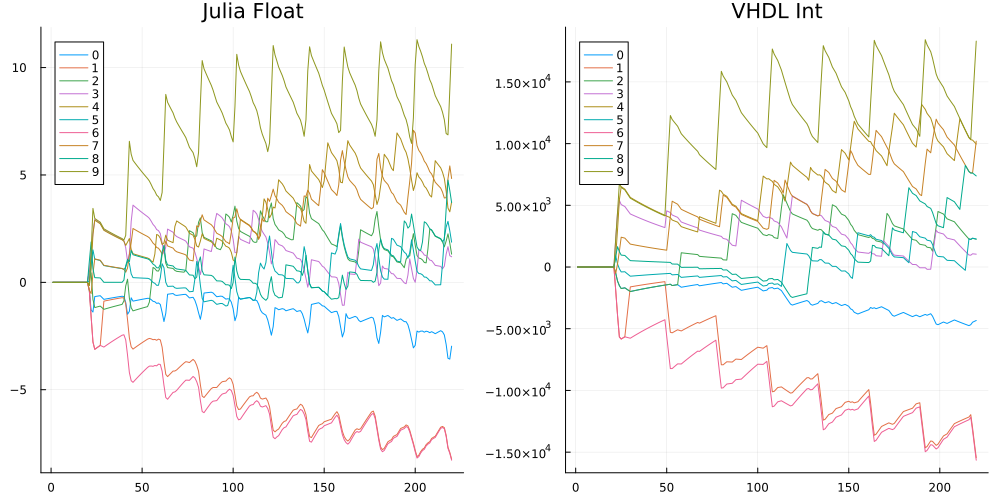

In [9]:
P1=plot(Rout, legend=:topleft, title="Julia Float",label = ["0" "1" "2" "3" "4" "5" "6" "7" "8" "9"]) #Méthode Florent
P2=plot(Routp, legend=:topleft, title="VHDL Int",label = ["0" "1" "2" "3" "4" "5" "6" "7" "8" "9"]) #Méthode Pascal

plot(P1,P2, layout=(1, 2), size=(1000,500))

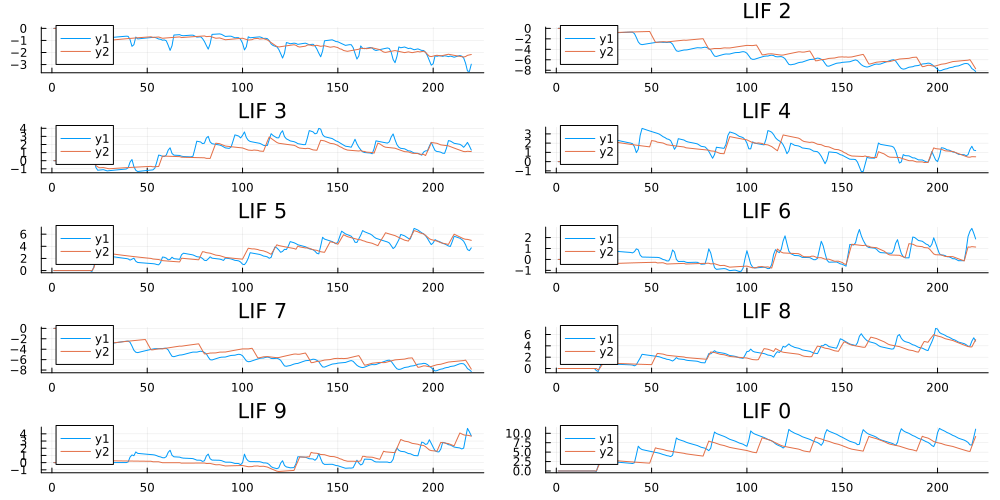

In [10]:
#Comparaison de l'évolution Rout et Routp rescalling
#---------------------------------------------------

P1=plot(Rout[:,1], legend=:left, ltitle="LIF 1")
P1=plot!((Routp[:,1]./2000))

P2=plot(Rout[:,2], legend=:left, title="LIF 2")
P2=plot!((Routp[:,2]./2000))

P3=plot(Rout[:,3], legend=:left, title="LIF 3")
P3=plot!((Routp[:,3]./2000))

P4=plot(Rout[:,4], legend=:left, title="LIF 4")
P4=plot!((Routp[:,4]./2000))

P5=plot(Rout[:,5], legend=:left, title="LIF 5")
P5=plot!((Routp[:,5]./2000))

P6=plot(Rout[:,6], legend=:left, title="LIF 6")
P6=plot!((Routp[:,6]./2000))

P7=plot(Rout[:,7], legend=:left, title="LIF 7")
P7=plot!((Routp[:,7]./2000))

P8=plot(Rout[:,8], legend=:left, title="LIF 8")
P8=plot!((Routp[:,8]./2000))

P9=plot(Rout[:,9], legend=:left, title="LIF 9")
P9=plot!((Routp[:,9]./2000))

P10=plot(Rout[:,10], legend=:left, title="LIF 0")
P10=plot!((Routp[:,10]./2000))

plot(P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,layout=(5, 2), size=(1000,500))